# Projeto MINST -reconhecimento de digitos - feito em dupla

* ARTUR DARTAGNAN DE OLIVEIRA VASCONCELOS - 20210026643
* José Augusto da Silva Barbosa - 20210094705

# Importando bibliotecas e Lendo arquivos

In [450]:
# Importar Biblioetecas

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import linalg as LA
import random


#Matriz de Confusão

from sklearn.metrics import confusion_matrix

In [451]:
# Leitura dos arquivos

def ler_excel(arq):
    
    # Retorna a lista já com as dimensões reduzidas -> posição 0 = label, posição 1 = intensidade, posicao 2 = simetria
    # A intensidade e simetria são normalizadas
    
    lista = pd.read_csv(arq, sep=';')

    lista_num = lista.to_numpy()
    
    


    lis =[]


    for x in lista_num:
        
        ir_lis =[]
        lis_b = np.zeros(28)
        ir_lis.append(x[0])
        ir_lis.append(np.sum(x[1:])/255)

        for y in range(28):
            
            c = x[y*28 + 1:y*28 + 29]
            c = c[0:14] - c[:13:-1]
            c = np.sqrt(c*c)
            lis_b[y] = np.sum(c)
            
        ir_lis.append(np.sum(lis_b)/255)

        lis.append(ir_lis)

    lis = np.array(lis)
    lis[:,1] = lis[:,1]/255
    lis[:,2] = lis[:,2]/255
    
    return lis

def ver_numero(arq,num):

    lista = pd.read_csv(arq, sep=';')

    lista_num = lista.to_numpy()

    g = np.ones((28,28))

    xx = lista_num[num]

    x = 0
    y = 0 
    
    com = True
    for yy in xx:
        if com:
            com = False
        else:
            g[x , y] = yy
            y+=1
            if y== 28:
                y = 0
                x += 1

    plt.imshow(g)

In [452]:
TreinoRedimensionado = ler_excel('train.csv') # Arquivo de treino já redimensionado
TesteRedimensionado = ler_excel('test.csv') # Arquivo de teste já redimensionado

In [453]:
# Funções Extras



# Funções Gráficas

def IntensidadeXSimetria(t):
    plt.scatter(t[:,1], t[:,2], c=t[:,0], cmap='viridis')
    plt.xlabel('Intensidade')
    plt.ylabel('Simetria')
    plt.title('Intensidade x Simetria')
    plt.show()

# Métricas de avaliação 

def modelo_metricas(y, predicted_y, minus1="-1", plus1="+1"):
    from sklearn.metrics import classification_report, confusion_matrix

    matriz_confusao = pd.DataFrame(confusion_matrix(y, predicted_y), index=[f'y {minus1}', f'y {plus1}'], columns=[f'pred {minus1}', f'pred {plus1}'])
    print("------------------ Matriz de confusão ------------------\n")
    print(matriz_confusao)
    print("\n-------- Relatório de eficácia de classificação --------\n")
    print(classification_report(y, predicted_y, target_names=[f"dígito {minus1}", f"dígito {plus1}"], zero_division=0))
    print("----------------------------------------------------------\n")

def getPrecisao(y, predicted_y):
    from sklearn.metrics import accuracy_score
    return accuracy_score(y, predicted_y)

# Algoritmos de Aprendizagem

In [454]:
class LRClassifier():
        
    def __init__(self):
        self.w = None
        
    
    def execute(self, _X, _y):
        #Recebe um vetor de features e um vetor de labels
        #Aplica o método da pseudo-inversa para encontrar os pesos:  𝐗† = (XTX)−1 XT;
        # print("Calculando pseudo-inversa...", end="")
        print("\b\b𝐗†\b\b")
        
        _X = np.array(_X)
        _y = np.array(_y)
        
        
        X_pinv = (np.linalg.inv(_X.T.dot(_X)).dot(_X.T))  
        self.w = X_pinv.dot(_y) # Cria Hipootese solução 
       
        
    def predict(self, _x,j=0):
        # #Recebe um vetor de features, e usa os coeficientes encontrados no método fit para fazer a predição 
        # _x = np.array(_x)    
        # return _x.dot(self.w)
        
        _x = np.array(_x)
        prediction = _x.dot(self.w)
        return np.where(prediction <= 0, -1, 1)

     
    def getRegressionY(self, regressionX, shift=0):
        
        # Função que retorna o valor de y para um dado x, considerando a equação da reta --> Uso na função plot do professor Gilberto
        
        return (-self.w[0]+shift - self.w[1]*regressionX) / self.w[2]
    
    def getW(self):
        return self.w


In [455]:
class PocketPLA():
    def __init__(self):
        self.w = None
    
    def get_w(self):
        return self.w
    
    def set_w(self, w):
        self.w = w

    def execute(self, _X, y):
        
        #Recebe um vetor de features e um vetor de labels
        #Aplica o método do Pocket PLA para encontrar os pesos
        # Limita o número de iterações a 100, e retorna o vetor de pesos que obteve o menor erro
        # Caso não encontre um vetor que classifique corretamente, retorna o vetor que obteve o menor erro
        
        X = np.array(_X)
        bestW = np.zeros(len(X[0]))
        bestError = len(y)
        self.w = np.zeros(len(X[0]))
        for iter in range(100):
            hasWrongClassifiedPoint = False
            for i in range(len(y)):
                if np.sign(np.dot(self.w, X[i])) != y[i]:
                    hasWrongClassifiedPoint = True
                    self.w = self.w + (y[i] * X[i])
                    eIN = self.errorIN(X, y)
                    if bestError > eIN:
                        bestError = eIN
                        bestW = np.copy(self.w)
            if not hasWrongClassifiedPoint:
                break
        self.w = bestW
        print("Número de iterações: ", iter)
                    
    def getOriginalY(self, originalX):
        
        # Função que retorna o valor de y para um dado x, considerando a equação da reta --> Uso na função plot do professor Gilberto
        
        if self.w[2] == 0:
            return float('inf')
        return (-self.w[0] - self.w[1] * originalX) / self.w[2]
    
    def predict(self, x,j = 0):
     
        # #Recebe um vetor de features, e usa os coeficientes encontrados no método fit para fazer a predição
        
        return np.sign(np.dot(self.w, x))
    
    def errorIN(self, X, y):
        error = 0
        for i in range(len(y)):
            if np.sign(np.dot(self.w, X[i])) != y[i]:
                error += 1
        return error


In [456]:
class LogisticRegression_1:
    
    #LogisticRegression(0.1, 10000, 64)
    def __init__(self, eta=0.1, tmax=10000, batch_size=64, lam=0):
        self.eta = eta
        self.tmax = tmax
        self.batch_size = batch_size
        self.lam = lam

    # Infere o vetor w da funçao hipotese
    # Executa a minimizao do erro de entropia cruzada pelo algoritmo gradiente de descida
    def fit(self,  X, y):
        self.w = []    
       
        #X = np.concatenate((np.ones((len(X),1), dtype=np.float64), np.array(X, dtype=np.float64)), axis=1)
        X = np.array(X, dtype=np.float64)
        y = np.array(y, dtype=np.float64)
        
        d = X.shape[1]
        N = X.shape[0]
        w = np.zeros(d, dtype=np.float64)
        
        for i in range(self.tmax):
            vsoma = np.zeros(d, dtype=np.float64)

            # Escolhendo o lote de entradas
            if self.batch_size < N:
                indices = random.sample(range(N),self.batch_size)
                batchX = [X[index] for index in indices]
                batchY = [y[index] for index in indices]
            else:
                batchX = X
                batchY = y

            # Computando o gradiente no ponto atual
            for xn, yn in zip(batchX, batchY):
                vsoma += (yn * xn) / (1 + np.exp((yn * w).T @ xn))
        
            gt = vsoma/self.batch_size 
            if self.lam != 0:
              gt += 2*self.lam * w
            
            # Condicao de parada: se ||deltaF|| < epsilon (0.0001)
            if LA.norm(gt) < 0.0001 :
                break
            w = w + (self.eta*gt)

        self.w = w

    def predict(self, X,w):
        
        resultado = np.dot(X, w)
        resultado = np.sign(resultado)
        return resultado
    
   



    def calcula_ein(self, w, X, y):
        y_pred = self.predict(w, X)
        return np.sum(y_pred != y)/len(y)

    def getW(self):
        return self.w

    
    def getRegressionY(self, regressionX, shift=0):
        return (-self.w[0]+shift - self.w[1]*regressionX) / self.w[2]

In [457]:
from sklearn.model_selection import train_test_split
import numpy as np

import warnings
warnings.filterwarnings("error")

class WeightDecay:
    # Infere o vetor w da funçao hipotese
    # Executa a heuristica Weigth Decay
    def fit(self,  X, y):
        training_x, testing_x, training_y, testing_y = train_test_split(X, y, test_size=0.2, random_state=2698)
        
        new_training_x = [0 for i in range(len(training_x))]
        for i in range(len(training_x)):
            new_training_x[i] = np.array([1, training_x[i][0], training_x[i][1]])

        
        lambdas = sorted([10 ** x for x in range(-5, 5)])
        #print(lambdas)
        lambdas.append(0)
        bestEout = 100
 
        for lam in lambdas:
            classifier = LogisticRegression_1(0.1, 10000, 64, lam)
            try:
                classifier.fit(training_x, training_y)
            except RuntimeWarning:
                continue

            #Computando o erro quadrático (Eout)
            eOut = self.getEout(classifier.predict(new_training_x, classifier.w), testing_y)

            
            #print("LA: " + str(classifier.lam) + "  Eval = " + str(eOut))
            if eOut < bestEout:
                bestEout = eOut
                self.classifier = classifier
                    
        self.w = self.classifier.w
        #print("Best Lamb: " + str(self.classifier.lam))
        
    #Predicao por classificação linear
    def predict(self, X, w):
        #print(X[0])
        #print(w)
        
        X = np.array(X, dtype=np.float64)
        w = np.array(w, dtype=np.float64)
        
        # X é 1184X3 e w é 3X1
        resultado = np.dot(w, X.T) 
   
        resultado = np.sign(resultado)
     
        return resultado

    def getW(self):
        return self.w
    
    def getEout(self, predicted_y_test, testing_y):
        #Computando o erro quadrático (Eout)
        N_val = len(testing_y)
        eOut = 0
        for i in range(N_val):
            if(predicted_y_test[i] != testing_y[i]):
                eOut += 1 
        eOut /= N_val
        return eOut
    
    def getRegressionY(self, regressionX, shift=0):
        return (-self.w[0]+shift - self.w[1]*regressionX) / self.w[2]


# Classificação 1 e 5 

In [458]:
# Primeiro elemento de cada linha que for 1 ou 5

# treino04 = TreinoRedimensionado[np.where((TreinoRedimensionado[:,0] == 0) | (TreinoRedimensionado[:,0] == 4))]
# teste04 = TesteRedimensionado[np.where((TesteRedimensionado[:,0] == 0) | (TesteRedimensionado[:,0] == 4))]

treino15 = TreinoRedimensionado[np.where((TreinoRedimensionado[:,0] == 1) | (TreinoRedimensionado[:,0] == 5))]
teste15 = TesteRedimensionado[np.where((TesteRedimensionado[:,0] == 1) | (TesteRedimensionado[:,0] == 5))]


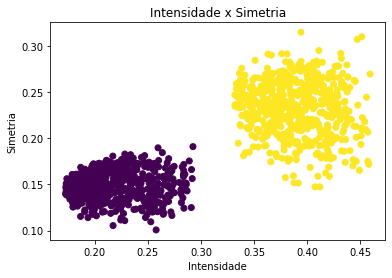

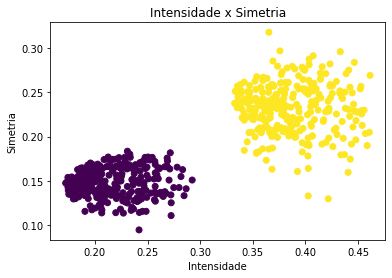

(None, None)

In [459]:
IntensidadeXSimetria(treino15), IntensidadeXSimetria(teste15)

In [460]:
xtreino15 = treino15[:,1:]
xteste15 = teste15[:,1:]

ytreino15 = treino15[:,0]
yteste15 = teste15[:,0]

# Atriuir 1 para 1 e -1 para 5

ytreino15 = np.where(ytreino15 == 1, 1, -1)
yteste15 = np.where(yteste15 == 1, 1, -1)



### Linear Regression Classifier

�


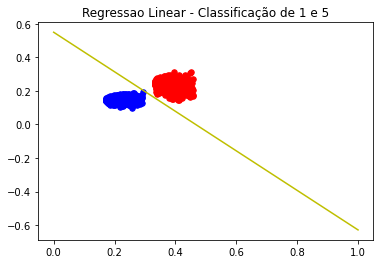

In [461]:
rX = [[1,x[0], x[1]] for x in  xtreino15]

N = len(rX)

clr15 = LRClassifier()
clr15.execute(rX, ytreino15)

#desenha a reta inferida pela regressao linear
xOri = [0, +1]
yOri = [clr15.getRegressionY(xOri[0]), clr15.getRegressionY(xOri[1])]
plt.plot(xOri, yOri, '-y', label='RL')
plt.title("Regressao Linear - Classificação de 1 e 5")

#plota os pontos classificados pela RL com bolinha azul(+) e vermelha(-)

pred = [clr15.predict(x) for x in rX]

xP = [rX[i][1] for i in range(N) if(pred[i] > 0)] # Vetor de x's dos pontos classificados como +1
yP = [rX[i][2] for i in range(N) if(pred[i] > 0)] # Vetor de y's dos pontos classificados como +1
xN = [rX[i][1] for i in range(N) if(pred[i] < 0)] # Vetor de x's dos pontos classificados como -1
yN = [rX[i][2] for i in range(N) if(pred[i] < 0)] # Vetor de y's dos pontos classificados como -1

plt.scatter(xP, yP, color='blue', marker='o', s=30) 
plt.scatter(xN, yN, color='red', marker='o', s=30)

# plt.scatter([rX[i][1] for i in range(N) if(pred[i] > 0)], [rX[i][2] for i in range(N) if(pred[i] > 0)], color='blue', marker='o', s=30)
# plt.scatter([rX[i][1] for i in range(N) if(pred[i] < 0)], [rX[i][2] for i in range(N) if(pred[i] < 0)], color='red', marker='o', s=30)

plt.show()

In [462]:
modelo_metricas(ytreino15, pred)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1      576        0
y +1        0      608

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       1.00      1.00      1.00       576
   dígito +1       1.00      1.00      1.00       608

    accuracy                           1.00      1184
   macro avg       1.00      1.00      1.00      1184
weighted avg       1.00      1.00      1.00      1184

----------------------------------------------------------



�


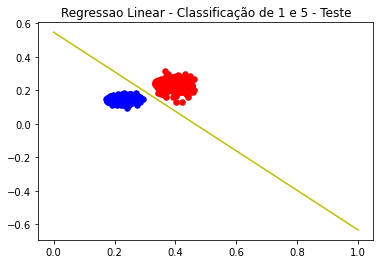

In [463]:

rX = [[1,x[0], x[1]] for x in  xteste15]


N = len(rX)


clr15.execute(rX, yteste15)



#desenha a reta inferida pela regressao linear
xOri = [0, +1]
yOri = [clr15.getRegressionY(xOri[0]), clr15.getRegressionY(xOri[1])]
plt.plot(xOri, yOri, '-y', label='RL')
plt.title("Regressao Linear - Classificação de 1 e 5 - Teste")

#plota os pontos classificados pela RL com bolinha azul(+) e vermelha(-)

pred = [clr15.predict(x) for x in rX]

xP = [rX[i][1] for i in range(N) if(pred[i] > 0)] # Vetor de x's dos pontos classificados como +1
yP = [rX[i][2] for i in range(N) if(pred[i] > 0)] # Vetor de y's dos pontos classificados como +1
xN = [rX[i][1] for i in range(N) if(pred[i] < 0)] # Vetor de x's dos pontos classificados como -1
yN = [rX[i][2] for i in range(N) if(pred[i] < 0)] # Vetor de y's dos pontos classificados como -1

plt.scatter(xP, yP, color='blue', marker='o', s=30)
plt.scatter(xN, yN, color='red', marker='o', s=30)

# plt.scatter([rX[i][1] for i in range(N) if(pred[i] > 0)], [rX[i][2] for i in range(N) if(pred[i] > 0)], color='blue', marker='o', s=30)
# plt.scatter([rX[i][1] for i in range(N) if(pred[i] < 0)], [rX[i][2] for i in range(N) if(pred[i] < 0)], color='red', marker='o', s=30)

plt.show()



In [464]:
modelo_metricas(yteste15, pred)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1      291        0
y +1        0      292

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       1.00      1.00      1.00       291
   dígito +1       1.00      1.00      1.00       292

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       583
weighted avg       1.00      1.00      1.00       583

----------------------------------------------------------



### PocketPla

Número de iterações:  14


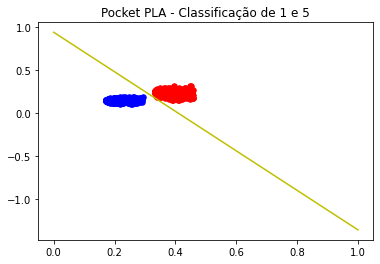

In [465]:
# executa o PLA sobre os dados de entrada X e y
rX = [[1, x[0], x[1]] for x in xtreino15]

pla = PocketPLA()
pla.execute(rX, ytreino15)

# desenha a reta inferida pelo PLA
xOri = [0, +1]
yOri = [pla.getOriginalY(x) for x in xOri]

plt.plot(xOri, yOri, '-y', label='g(.)')  # reta inferida pelo PLA


predict = [pla.predict(x) for x in rX]

xP = [xtreino15[i][0] for i in range(len(xtreino15)) if predict[i] > 0]
yP = [xtreino15[i][1] for i in range(len(xtreino15)) if predict[i] > 0]

xN = [xtreino15[i][0] for i in range(len(xtreino15)) if predict[i] < 0]
yN = [xtreino15[i][1] for i in range(len(xtreino15)) if predict[i] < 0]

plt.scatter(xP, yP, color='blue', marker='o', s=30)
plt.scatter(xN, yN, color='red', marker='o', s=30)
plt.title("Pocket PLA - Classificação de 1 e 5")
plt.show()

In [466]:
modelo_metricas(ytreino15, predict)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1      576        0
y +1        0      608

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       1.00      1.00      1.00       576
   dígito +1       1.00      1.00      1.00       608

    accuracy                           1.00      1184
   macro avg       1.00      1.00      1.00      1184
weighted avg       1.00      1.00      1.00      1184

----------------------------------------------------------



Número de iterações:  13


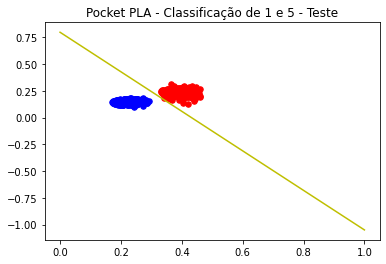

In [467]:
# executa o PLA sobre os dados de entrada X e y
rX = [[1, x[0], x[1]] for x in xteste15]


pla.execute(rX, yteste15)

# desenha a reta inferida pelo PLA
xOri = [0, +1]
yOri = [pla.getOriginalY(x) for x in xOri]
plt.plot(xOri, yOri, '-y', label='g(.)')  # reta inferida pelo PLA


predict = [pla.predict(x) for x in rX]

xP = [xteste15[i][0] for i in range(len(xteste15)) if predict[i] > 0]
yP = [xteste15[i][1] for i in range(len(xteste15)) if predict[i] > 0]

xN = [xteste15[i][0] for i in range(len(xteste15)) if predict[i] < 0]
yN = [xteste15[i][1] for i in range(len(xteste15)) if predict[i] < 0]

plt.scatter(xP, yP, color='blue', marker='o', s=30)
plt.scatter(xN, yN, color='red', marker='o', s=30)
plt.title("Pocket PLA - Classificação de 1 e 5 - Teste")
plt.show()

In [468]:
modelo_metricas(yteste15, predict)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1      291        0
y +1        0      292

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       1.00      1.00      1.00       291
   dígito +1       1.00      1.00      1.00       292

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       583
weighted avg       1.00      1.00      1.00       583

----------------------------------------------------------



### Logistic Regression Classifier

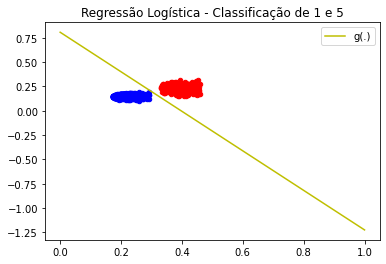

In [469]:
rx = [[1, x[0], x[1]] for x in xtreino15]

# Executar o ajuste dos dados com Regressão Logística
#classifier = LogisticRegression_1()
clog15 = LogisticRegression_1(0.1, 10000, 64)
#classifier = LogisticRegressionGradientDescendent()


clog15.fit(rx, ytreino15)

# Plota as porcentagens da Regressão Logística
pred = clog15.predict(rx,clog15.w)



# Desenha a reta inferida pela regressão logística
xRL = [0, +1]


yRL = [clog15.getRegressionY(x) for x in xRL]
plt.plot(xRL, yRL, 'y-', label='g(.)')
plt.legend(loc='upper right')

# Plota os pontos classificados pela RL com bolinha azul(+) e vermelha(-)
xP = [rx[i][1] for i in range(len(rx)) if pred[i] >= 0.5]
yP = [rx[i][2] for i in range(len(rx)) if pred[i] >= 0.5]
xN = [rx[i][1] for i in range(len(rx)) if pred[i] < 0.5]
yN = [rx[i][2] for i in range(len(rx)) if pred[i] < 0.5]

plt.scatter(xP, yP, color='blue', marker='o', s=20)
plt.scatter(xN, yN, color='red', marker='o', s=20)

plt.title("Regressão Logística - Classificação de 1 e 5")
plt.show()

In [470]:
modelo_metricas(ytreino15, pred)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1      576        0
y +1        0      608

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       1.00      1.00      1.00       576
   dígito +1       1.00      1.00      1.00       608

    accuracy                           1.00      1184
   macro avg       1.00      1.00      1.00      1184
weighted avg       1.00      1.00      1.00      1184

----------------------------------------------------------



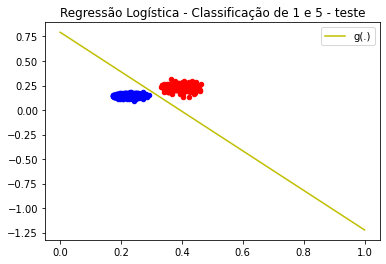

In [471]:
rx = [[1, x[0], x[1]] for x in xteste15]

# Executar o ajuste dos dados com Regressão Logística

#classifier = LogisticRegressionGradientDescendent()
clog15.fit(rx, yteste15)

# Plota as porcentagens da Regressão Logística
pred = clog15.predict(rx,clog15.w)

# for x, pred_x in zip(rx, pred):
#     plt.annotate("{:.2f}".format(pred_x), xy=(x[1], x[2]), xytext=(5,-5), textcoords='offset points')

# Desenha a reta inferida pela regressão logística
xRL = [0, +1]


yRL = [clog15.getRegressionY(x) for x in xRL]
plt.plot(xRL, yRL, 'y-', label='g(.)')
plt.legend(loc='upper right')

# Plota os pontos classificados pela RL com bolinha azul(+) e vermelha(-)
xP = [rx[i][1] for i in range(len(rx)) if pred[i] >= 0.5]
yP = [rx[i][2] for i in range(len(rx)) if pred[i] >= 0.5]
xN = [rx[i][1] for i in range(len(rx)) if pred[i] < 0.5]
yN = [rx[i][2] for i in range(len(rx)) if pred[i] < 0.5]

plt.scatter(xP, yP, color='blue', marker='o', s=20)
plt.scatter(xN, yN, color='red', marker='o', s=20)

plt.title("Regressão Logística - Classificação de 1 e 5 - teste")
plt.show()

In [472]:
modelo_metricas(yteste15, pred)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1      291        0
y +1        0      292

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       1.00      1.00      1.00       291
   dígito +1       1.00      1.00      1.00       292

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       583
weighted avg       1.00      1.00      1.00       583

----------------------------------------------------------



### Weight Decay

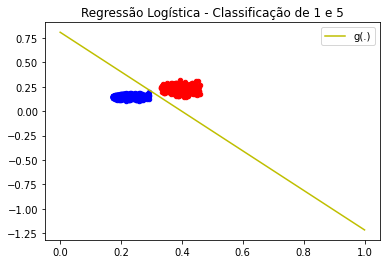

In [473]:
rx = [[1, x[0], x[1]] for x in xtreino15]

wd15 = WeightDecay()

wd15.fit(rx, ytreino15)

pred = wd15.predict(rx, wd15.w)


xRL = [0, +1]
yRL = [wd15.getRegressionY(x) for x in xRL]

plt.plot(xRL, yRL, 'y-', label='g(.)')
plt.legend(loc='upper right')


xP = [rx[i][1] for i in range(len(rx)) if pred[i] >= 0]
yP = [rx[i][2] for i in range(len(rx)) if pred[i] >= 0]

xN = [rx[i][1] for i in range(len(rx)) if pred[i] < 0]
yN = [rx[i][2] for i in range(len(rx)) if pred[i] < 0]


plt.scatter(xP, yP, color='blue', marker='o', s=20)
plt.scatter(xN, yN, color='red', marker='o', s=20)






plt.title("Regressão Logística - Classificação de 1 e 5")
plt.show()


In [474]:
modelo_metricas(ytreino15, pred)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1      576        0
y +1        0      608

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       1.00      1.00      1.00       576
   dígito +1       1.00      1.00      1.00       608

    accuracy                           1.00      1184
   macro avg       1.00      1.00      1.00      1184
weighted avg       1.00      1.00      1.00      1184

----------------------------------------------------------



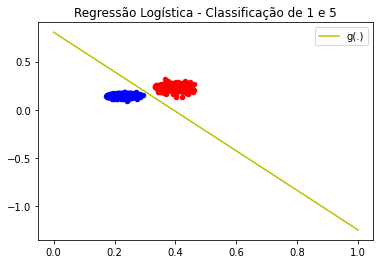

In [475]:
rx = [[1, x[0], x[1]] for x in xteste15]



wd15.fit(rx, yteste15)

pred = wd15.predict(rx, wd15.w)


xRL = [0, +1]
yRL = [wd15.getRegressionY(x) for x in xRL]

plt.plot(xRL, yRL, 'y-', label='g(.)')
plt.legend(loc='upper right')


xP = [rx[i][1] for i in range(len(rx)) if pred[i] >= 0]
yP = [rx[i][2] for i in range(len(rx)) if pred[i] >= 0]

xN = [rx[i][1] for i in range(len(rx)) if pred[i] < 0]
yN = [rx[i][2] for i in range(len(rx)) if pred[i] < 0]


plt.scatter(xP, yP, color='blue', marker='o', s=20)
plt.scatter(xN, yN, color='red', marker='o', s=20)






plt.title("Regressão Logística - Classificação de 1 e 5")
plt.show()


In [476]:
modelo_metricas(yteste15, pred)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1      291        0
y +1        0      292

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       1.00      1.00      1.00       291
   dígito +1       1.00      1.00      1.00       292

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       583
weighted avg       1.00      1.00      1.00       583

----------------------------------------------------------



# Estratégia 1 contra todos

* cztlr  = classificador zerro contra todos linear regression
* cztpp  = classificador zero contra todos pocket PLA
* cztlog = classificador zeero contra todos logistic regression
* cztwd = classificador  zeero contra todos weight Decay


* cutlr  = classificador um contra resto linear regression
* cutpp  = classificador um contra resto pocket PLA
* cutlog = classificador um contra resto logistic regression
* cztwd = classificador  um contra todos weight Decay

* cqtlr  = classificador quatro contra resto linear regression
* cqtpp  = classificador quatro contra resto pocket PLA
* cqzlog = classificador quatro contra resto logistic regression
* cztwd = classificador  quatro contra todos weight Decay

---> Usa a estratégia de um contra todos, veja se target é ou não daquela classe, <br/>
---> Caso não elimine-a, e teste escolhendo outro target, caso não for nenhum dos anteriores <br/>
---> O target restante sera o retorno <br/>

In [477]:
best_classifiers_zt = []
best_classifiers_ut = []
best_classifiers_qt = []
best_classifiers_ct = []

## 0 Vs Todos

In [478]:
# teste15 = TesteRedimensionado[np.where((TesteRedimensionado[:,0] == 1) | (TesteRedimensionado[:,0] == 5))]
treinozt = TreinoRedimensionado.copy()
testezt = TesteRedimensionado.copy()

xtreinozt = treinozt[:,1:]
xtestezt = testezt[:,1:]

ytreinozt = treinozt[:,0]
ytestezt = testezt[:,0]


# Atriuir 1 para 0 e -1 para o resto

ytreinozt = np.where(ytreinozt == 0, 1, -1)
ytestezt = np.where(ytestezt == 0, 1, -1)





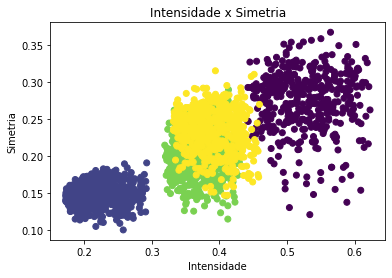

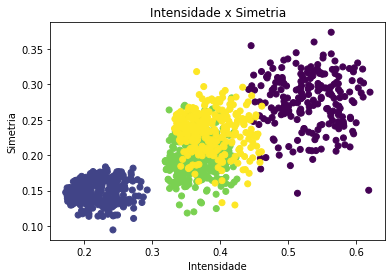

(None, None)

In [479]:
IntensidadeXSimetria(treinozt), IntensidadeXSimetria(testezt)

##### Linear Regression Classifier

�


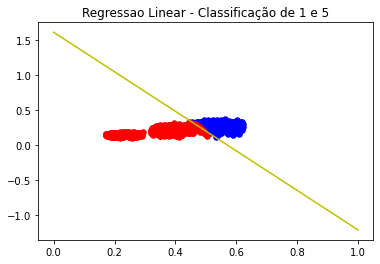

In [480]:
rX = [[1,x[0], x[1]] for x in  xtreinozt]

N = len(rX)

cztlr = LRClassifier()
cztlr.execute(rX, ytreinozt)


#desenha a reta inferida pela regressao linear
xOri = [0, +1]
yOri = [cztlr.getRegressionY(xOri[0]), cztlr.getRegressionY(xOri[1])]
plt.plot(xOri, yOri, '-y', label='RL')
plt.title("Regressao Linear - Classificação de 1 e 5")

#plota os pontos classificados pela RL com bolinha azul(+) e vermelha(-)

pred = [cztlr.predict(x) for x in rX]

xP = [rX[i][1] for i in range(N) if(pred[i] > 0)] # Vetor de x's dos pontos classificados como +1
yP = [rX[i][2] for i in range(N) if(pred[i] > 0)] # Vetor de y's dos pontos classificados como +1
xN = [rX[i][1] for i in range(N) if(pred[i] < 0)] # Vetor de x's dos pontos classificados como -1
yN = [rX[i][2] for i in range(N) if(pred[i] < 0)] # Vetor de y's dos pontos classificados como -1

plt.scatter(xP, yP, color='blue', marker='o', s=30) 
plt.scatter(xN, yN, color='red', marker='o', s=30)

# plt.scatter([rX[i][1] for i in range(N) if(pred[i] > 0)], [rX[i][2] for i in range(N) if(pred[i] > 0)], color='blue', marker='o', s=30)
# plt.scatter([rX[i][1] for i in range(N) if(pred[i] < 0)], [rX[i][2] for i in range(N) if(pred[i] < 0)], color='red', marker='o', s=30)

# Eixo X = Intensidade Eixo Y = Simetria



plt.show()

In [481]:
modelo_metricas(ytreinozt, pred)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1     1761        0
y +1       64      361

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       0.96      1.00      0.98      1761
   dígito +1       1.00      0.85      0.92       425

    accuracy                           0.97      2186
   macro avg       0.98      0.92      0.95      2186
weighted avg       0.97      0.97      0.97      2186

----------------------------------------------------------



�


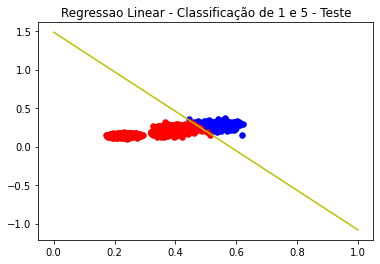

In [482]:

rX = [[1,x[0], x[1]] for x in  xtestezt]


N = len(rX)


cztlr.execute(rX, ytestezt)



#desenha a reta inferida pela regressao linear
xOri = [0, +1]
yOri = [cztlr.getRegressionY(xOri[0]), cztlr.getRegressionY(xOri[1])]
plt.plot(xOri, yOri, '-y', label='RL')
plt.title("Regressao Linear - Classificação de 1 e 5 - Teste")

#plota os pontos classificados pela RL com bolinha azul(+) e vermelha(-)

pred = [cztlr.predict(x) for x in rX]

xP = [rX[i][1] for i in range(N) if(pred[i] > 0)] # Vetor de x's dos pontos classificados como +1
yP = [rX[i][2] for i in range(N) if(pred[i] > 0)] # Vetor de y's dos pontos classificados como +1
xN = [rX[i][1] for i in range(N) if(pred[i] < 0)] # Vetor de x's dos pontos classificados como -1
yN = [rX[i][2] for i in range(N) if(pred[i] < 0)] # Vetor de y's dos pontos classificados como -1

plt.scatter(xP, yP, color='blue', marker='o', s=30)
plt.scatter(xN, yN, color='red', marker='o', s=30)

# plt.scatter([rX[i][1] for i in range(N) if(pred[i] > 0)], [rX[i][2] for i in range(N) if(pred[i] > 0)], color='blue', marker='o', s=30)
# plt.scatter([rX[i][1] for i in range(N) if(pred[i] < 0)], [rX[i][2] for i in range(N) if(pred[i] < 0)], color='red', marker='o', s=30)

plt.show()



In [483]:
modelo_metricas(ytestezt, pred)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1      897        0
y +1       24      194

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       0.97      1.00      0.99       897
   dígito +1       1.00      0.89      0.94       218

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

----------------------------------------------------------



In [484]:
best_classifiers_zt.append(getPrecisao(ytestezt, pred))

##### Pocket PLA

Número de iterações:  99


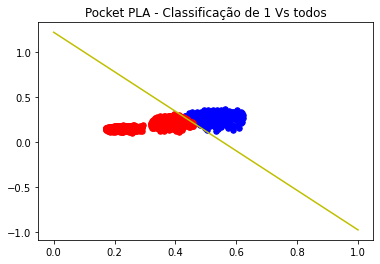

In [485]:
# executa o PLA sobre os dados de entrada X e y
rX = [[1, x[0], x[1]] for x in xtreinozt]


cztpp = PocketPLA()
cztpp.execute(rX, ytreinozt)

# desenha a reta inferida pelo PLA
xOri = [0, +1]
yOri = [cztpp.getOriginalY(x) for x in xOri]

plt.plot(xOri, yOri, '-y', label='g(.)')  # reta inferida pelo PLA


predict = [cztpp.predict(x) for x in rX]

xP = [rX[i][1] for i in range(len(rX)) if predict[i] > 0]
yP = [rX[i][2] for i in range(len(rX)) if predict[i] > 0]

xN = [rX[i][1] for i in range(len(rX)) if predict[i] < 0]
yN = [rX[i][2] for i in range(len(rX)) if predict[i] < 0]

plt.scatter(xP, yP, color='blue', marker='o', s=30)
plt.scatter(xN, yN, color='red', marker='o', s=30)
plt.title("Pocket PLA - Classificação de 1 Vs todos")
plt.show()

In [486]:
modelo_metricas(ytreinozt, predict)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1     1745       16
y +1        2      423

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       1.00      0.99      0.99      1761
   dígito +1       0.96      1.00      0.98       425

    accuracy                           0.99      2186
   macro avg       0.98      0.99      0.99      2186
weighted avg       0.99      0.99      0.99      2186

----------------------------------------------------------



Número de iterações:  99


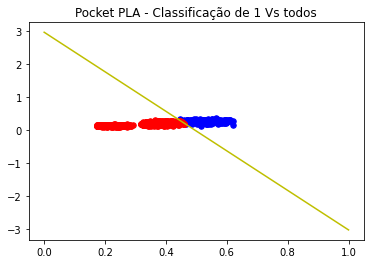

In [487]:
# executa o PLA sobre os dados de entrada X e y
rX = [[1, x[0], x[1]] for x in xtestezt]



cztpp.execute(rX, ytestezt)

# desenha a reta inferida pelo PLA
xOri = [0, +1]
yOri = [cztpp.getOriginalY(x) for x in xOri]

plt.plot(xOri, yOri, '-y', label='g(.)')  # reta inferida pelo PLA


predict = [cztpp.predict(x) for x in rX]

xP = [rX[i][1] for i in range(len(rX)) if predict[i] > 0]
yP = [rX[i][2] for i in range(len(rX)) if predict[i] > 0]

xN = [rX[i][1] for i in range(len(rX)) if predict[i] < 0]
yN = [rX[i][2] for i in range(len(rX)) if predict[i] < 0]

plt.scatter(xP, yP, color='blue', marker='o', s=30)
plt.scatter(xN, yN, color='red', marker='o', s=30)
plt.title("Pocket PLA - Classificação de 1 Vs todos")
plt.show()

In [488]:
modelo_metricas(ytestezt, predict)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1      896        1
y +1        5      213

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       0.99      1.00      1.00       897
   dígito +1       1.00      0.98      0.99       218

    accuracy                           0.99      1115
   macro avg       0.99      0.99      0.99      1115
weighted avg       0.99      0.99      0.99      1115

----------------------------------------------------------



In [489]:
best_classifiers_zt.append(getPrecisao(ytestezt, predict))

##### Logistic Regression Classifier

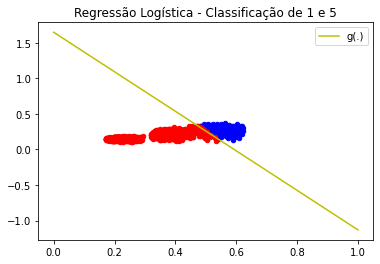

In [490]:
rx = [[1, x[0], x[1]] for x in xtreinozt]

# Executar o ajuste dos dados com Regressão Logística
cztlog = LogisticRegression_1()

cztlog.fit(rx, ytreinozt)

# Plota as porcentagens da Regressão Logística
pred = cztlog.predict(rx,cztlog.w)


xRL = [0, +1]


yRL = [cztlog.getRegressionY(x) for x in xRL]
plt.plot(xRL, yRL, 'y-', label='g(.)')
plt.legend(loc='upper right')

# Plota os pontos classificados pela RL com bolinha azul(+) e vermelha(-)
xP = [rx[i][1] for i in range(len(rx)) if pred[i] >= 0.5]
yP = [rx[i][2] for i in range(len(rx)) if pred[i] >= 0.5]
xN = [rx[i][1] for i in range(len(rx)) if pred[i] < 0.5]
yN = [rx[i][2] for i in range(len(rx)) if pred[i] < 0.5]

plt.scatter(xP, yP, color='blue', marker='o', s=20)
plt.scatter(xN, yN, color='red', marker='o', s=20)

plt.title("Regressão Logística - Classificação de 1 e 5")
plt.show()

In [491]:
modelo_metricas(ytreinozt, pred)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1     1761        0
y +1      112      313

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       0.94      1.00      0.97      1761
   dígito +1       1.00      0.74      0.85       425

    accuracy                           0.95      2186
   macro avg       0.97      0.87      0.91      2186
weighted avg       0.95      0.95      0.95      2186

----------------------------------------------------------



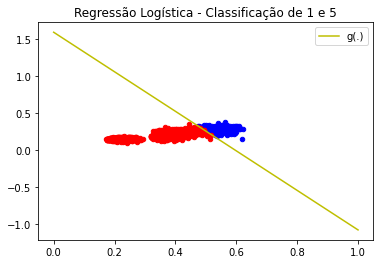

In [492]:
rx = [[1, x[0], x[1]] for x in xtestezt]



cztlog.fit(rx, ytestezt)

# Plota as porcentagens da Regressão Logística
pred = cztlog.predict(rx,cztlog.w)


xRL = [0, +1]


yRL = [cztlog.getRegressionY(x) for x in xRL]
plt.plot(xRL, yRL, 'y-', label='g(.)')
plt.legend(loc='upper right')

# Plota os pontos classificados pela RL com bolinha azul(+) e vermelha(-)
xP = [rx[i][1] for i in range(len(rx)) if pred[i] >= 0.5]
yP = [rx[i][2] for i in range(len(rx)) if pred[i] >= 0.5]
xN = [rx[i][1] for i in range(len(rx)) if pred[i] < 0.5]
yN = [rx[i][2] for i in range(len(rx)) if pred[i] < 0.5]

plt.scatter(xP, yP, color='blue', marker='o', s=20)
plt.scatter(xN, yN, color='red', marker='o', s=20)

plt.title("Regressão Logística - Classificação de 1 e 5")
plt.show()

In [493]:
modelo_metricas(ytestezt, pred)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1      897        0
y +1       46      172

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       0.95      1.00      0.97       897
   dígito +1       1.00      0.79      0.88       218

    accuracy                           0.96      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.96      0.96      0.96      1115

----------------------------------------------------------



In [494]:
best_classifiers_zt.append(getPrecisao(ytestezt, pred))

##### Weight decay

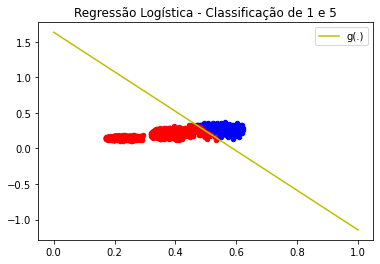

In [495]:
rx = [[1, x[0], x[1]] for x in xtreinozt]

cztwd = WeightDecay()

cztwd.fit(rx, ytreinozt)

pred = cztwd.predict(rx, cztwd.w)


xRL = [0, +1]
yRL = [cztwd.getRegressionY(x) for x in xRL]

plt.plot(xRL, yRL, 'y-', label='g(.)')
plt.legend(loc='upper right')


xP = [rx[i][1] for i in range(len(rx)) if pred[i] >= 0]
yP = [rx[i][2] for i in range(len(rx)) if pred[i] >= 0]

xN = [rx[i][1] for i in range(len(rx)) if pred[i] < 0]
yN = [rx[i][2] for i in range(len(rx)) if pred[i] < 0]


plt.scatter(xP, yP, color='blue', marker='o', s=20)
plt.scatter(xN, yN, color='red', marker='o', s=20)






plt.title("Regressão Logística - Classificação de 1 e 5")
plt.show()


In [496]:
modelo_metricas(ytreinozt, pred)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1     1761        0
y +1       95      330

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       0.95      1.00      0.97      1761
   dígito +1       1.00      0.78      0.87       425

    accuracy                           0.96      2186
   macro avg       0.97      0.89      0.92      2186
weighted avg       0.96      0.96      0.95      2186

----------------------------------------------------------



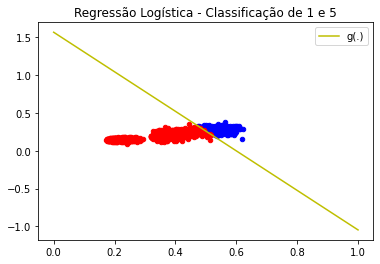

In [497]:
rx = [[1, x[0], x[1]] for x in xtestezt]



cztwd.fit(rx, ytestezt)

pred = cztwd.predict(rx, cztwd.w)


xRL = [0, +1]
yRL = [cztwd.getRegressionY(x) for x in xRL]

plt.plot(xRL, yRL, 'y-', label='g(.)')
plt.legend(loc='upper right')


xP = [rx[i][1] for i in range(len(rx)) if pred[i] >= 0]
yP = [rx[i][2] for i in range(len(rx)) if pred[i] >= 0]

xN = [rx[i][1] for i in range(len(rx)) if pred[i] < 0]
yN = [rx[i][2] for i in range(len(rx)) if pred[i] < 0]


plt.scatter(xP, yP, color='blue', marker='o', s=20)
plt.scatter(xN, yN, color='red', marker='o', s=20)






plt.title("Regressão Logística - Classificação de 1 e 5")
plt.show()


In [498]:
modelo_metricas(ytestezt, pred)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1      897        0
y +1       47      171

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       0.95      1.00      0.97       897
   dígito +1       1.00      0.78      0.88       218

    accuracy                           0.96      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.96      0.96      0.96      1115

----------------------------------------------------------



In [499]:
best_classifiers_zt.append(getPrecisao(ytestezt, pred))

## 1 Vs Resto

In [500]:
treinut = TreinoRedimensionado.copy()
testeut = TesteRedimensionado.copy()

# retirar os 0

treinut = treinut[treinut[:,0] != 0] 
testeut = testeut[testeut[:,0] != 0]


xtreinut = treinut[:,1:]
xtesteut = testeut[:,1:]

ytreinut = treinut[:,0]
ytesteut = testeut[:,0]

# atribuir 1 para 1 e -1 para o resto

ytreinut = np.where(ytreinut == 1, 1, -1)
ytesteut = np.where(ytesteut == 1, 1, -1)



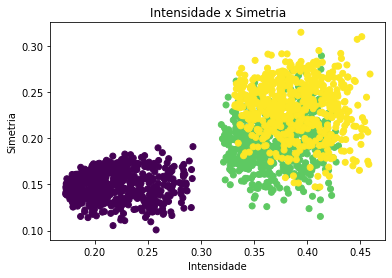

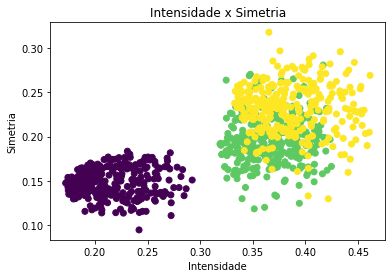

(None, None)

In [501]:
IntensidadeXSimetria(treinut), IntensidadeXSimetria(testeut)

#### Linear Regression Classifier

�


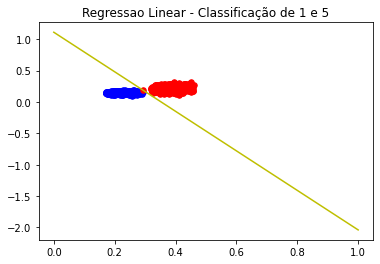

In [502]:
rX = [[1,x[0], x[1]] for x in  xtreinut]

N = len(rX)

cutlr = LRClassifier()
cutlr.execute(rX, ytreinut)


#desenha a reta inferida pela regressao linear
xOri = [0, +1]
yOri = [cutlr.getRegressionY(xOri[0]), cutlr.getRegressionY(xOri[1])]
plt.plot(xOri, yOri, '-y', label='RL')
plt.title("Regressao Linear - Classificação de 1 e 5")

#plota os pontos classificados pela RL com bolinha azul(+) e vermelha(-)

pred = [cutlr.predict(x) for x in rX]

xP = [rX[i][1] for i in range(N) if(pred[i] > 0)] # Vetor de x's dos pontos classificados como +1
yP = [rX[i][2] for i in range(N) if(pred[i] > 0)] # Vetor de y's dos pontos classificados como +1
xN = [rX[i][1] for i in range(N) if(pred[i] < 0)] # Vetor de x's dos pontos classificados como -1
yN = [rX[i][2] for i in range(N) if(pred[i] < 0)] # Vetor de y's dos pontos classificados como -1

plt.scatter(xP, yP, color='blue', marker='o', s=30) 
plt.scatter(xN, yN, color='red', marker='o', s=30)

# plt.scatter([rX[i][1] for i in range(N) if(pred[i] > 0)], [rX[i][2] for i in range(N) if(pred[i] > 0)], color='blue', marker='o', s=30)
# plt.scatter([rX[i][1] for i in range(N) if(pred[i] < 0)], [rX[i][2] for i in range(N) if(pred[i] < 0)], color='red', marker='o', s=30)

# Eixo X = Intensidade Eixo Y = Simetria



plt.show()

In [503]:
modelo_metricas(ytreinut, pred)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1     1153        0
y +1        1      607

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       1.00      1.00      1.00      1153
   dígito +1       1.00      1.00      1.00       608

    accuracy                           1.00      1761
   macro avg       1.00      1.00      1.00      1761
weighted avg       1.00      1.00      1.00      1761

----------------------------------------------------------



�


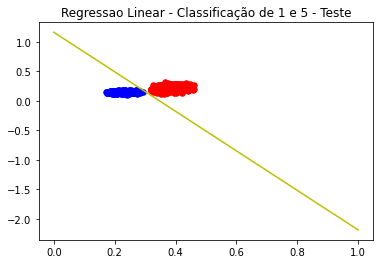

In [504]:

rX = [[1,x[0], x[1]] for x in  xtesteut]


N = len(rX)


cutlr.execute(rX, ytesteut)



#desenha a reta inferida pela regressao linear
xOri = [0, +1]
yOri = [cutlr.getRegressionY(xOri[0]), cutlr.getRegressionY(xOri[1])]
plt.plot(xOri, yOri, '-y', label='RL')
plt.title("Regressao Linear - Classificação de 1 e 5 - Teste")

#plota os pontos classificados pela RL com bolinha azul(+) e vermelha(-)

pred = [cutlr.predict(x) for x in rX]

xP = [rX[i][1] for i in range(N) if(pred[i] > 0)] # Vetor de x's dos pontos classificados como +1
yP = [rX[i][2] for i in range(N) if(pred[i] > 0)] # Vetor de y's dos pontos classificados como +1
xN = [rX[i][1] for i in range(N) if(pred[i] < 0)] # Vetor de x's dos pontos classificados como -1
yN = [rX[i][2] for i in range(N) if(pred[i] < 0)] # Vetor de y's dos pontos classificados como -1

plt.scatter(xP, yP, color='blue', marker='o', s=30)
plt.scatter(xN, yN, color='red', marker='o', s=30)

# plt.scatter([rX[i][1] for i in range(N) if(pred[i] > 0)], [rX[i][2] for i in range(N) if(pred[i] > 0)], color='blue', marker='o', s=30)
# plt.scatter([rX[i][1] for i in range(N) if(pred[i] < 0)], [rX[i][2] for i in range(N) if(pred[i] < 0)], color='red', marker='o', s=30)

plt.show()



In [505]:
modelo_metricas(ytesteut, pred)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1      605        0
y +1        0      292

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       1.00      1.00      1.00       605
   dígito +1       1.00      1.00      1.00       292

    accuracy                           1.00       897
   macro avg       1.00      1.00      1.00       897
weighted avg       1.00      1.00      1.00       897

----------------------------------------------------------



In [506]:
best_classifiers_ut.append(getPrecisao(ytesteut, pred))

#### Pocket PLA

Número de iterações:  22


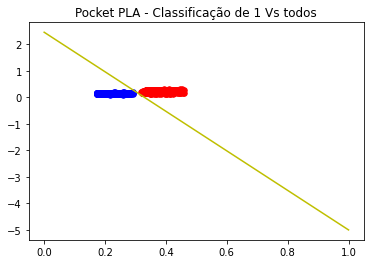

In [507]:
# executa o PLA sobre os dados de entrada X e y
rX = [[1, x[0], x[1]] for x in xtreinut]


cutpp = PocketPLA()
cutpp.execute(rX, ytreinut)

# desenha a reta inferida pelo PLA
xOri = [0, +1]
yOri = [cutpp.getOriginalY(x) for x in xOri]

plt.plot(xOri, yOri, '-y', label='g(.)')  # reta inferida pelo PLA


predict = [cutpp.predict(x) for x in rX]

xP = [rX[i][1] for i in range(len(rX)) if predict[i] > 0]
yP = [rX[i][2] for i in range(len(rX)) if predict[i] > 0]

xN = [rX[i][1] for i in range(len(rX)) if predict[i] < 0]
yN = [rX[i][2] for i in range(len(rX)) if predict[i] < 0]

plt.scatter(xP, yP, color='blue', marker='o', s=30)
plt.scatter(xN, yN, color='red', marker='o', s=30)
plt.title("Pocket PLA - Classificação de 1 Vs todos")
plt.show()

In [508]:
modelo_metricas(ytreinut, predict)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1     1153        0
y +1        0      608

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       1.00      1.00      1.00      1153
   dígito +1       1.00      1.00      1.00       608

    accuracy                           1.00      1761
   macro avg       1.00      1.00      1.00      1761
weighted avg       1.00      1.00      1.00      1761

----------------------------------------------------------



Número de iterações:  19


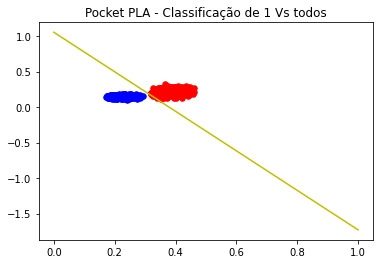

In [509]:
# executa o PLA sobre os dados de entrada X e y
rX = [[1, x[0], x[1]] for x in xtesteut]



cutpp.execute(rX, ytesteut)

# desenha a reta inferida pelo PLA
xOri = [0, +1]
yOri = [cutpp.getOriginalY(x) for x in xOri]

plt.plot(xOri, yOri, '-y', label='g(.)')  # reta inferida pelo PLA


predict = [cutpp.predict(x) for x in rX]

xP = [rX[i][1] for i in range(len(rX)) if predict[i] > 0]
yP = [rX[i][2] for i in range(len(rX)) if predict[i] > 0]

xN = [rX[i][1] for i in range(len(rX)) if predict[i] < 0]
yN = [rX[i][2] for i in range(len(rX)) if predict[i] < 0]

plt.scatter(xP, yP, color='blue', marker='o', s=30)
plt.scatter(xN, yN, color='red', marker='o', s=30)
plt.title("Pocket PLA - Classificação de 1 Vs todos")
plt.show()

In [510]:
modelo_metricas(ytesteut, predict)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1      605        0
y +1        0      292

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       1.00      1.00      1.00       605
   dígito +1       1.00      1.00      1.00       292

    accuracy                           1.00       897
   macro avg       1.00      1.00      1.00       897
weighted avg       1.00      1.00      1.00       897

----------------------------------------------------------



In [511]:
best_classifiers_ut.append(getPrecisao(ytesteut, predict))

#### Logistic regression Classifier

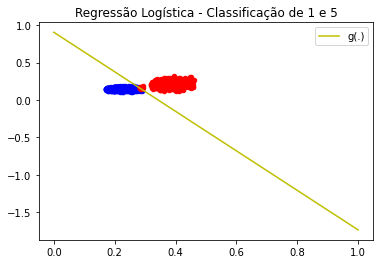

In [512]:
rx = [[1, x[0], x[1]] for x in xtreinut]

# Executar o ajuste dos dados com Regressão Logística
cutlog = LogisticRegression_1()

cutlog.fit(rx, ytreinut)

# Plota as porcentagens da Regressão Logística
pred = cutlog.predict(rx,cutlog.w)


xRL = [0, +1]


yRL = [cutlog.getRegressionY(x) for x in xRL]
plt.plot(xRL, yRL, 'y-', label='g(.)')
plt.legend(loc='upper right')

# Plota os pontos classificados pela RL com bolinha azul(+) e vermelha(-)
xP = [rx[i][1] for i in range(len(rx)) if pred[i] >= 0.5]
yP = [rx[i][2] for i in range(len(rx)) if pred[i] >= 0.5]
xN = [rx[i][1] for i in range(len(rx)) if pred[i] < 0.5]
yN = [rx[i][2] for i in range(len(rx)) if pred[i] < 0.5]

plt.scatter(xP, yP, color='blue', marker='o', s=20)
plt.scatter(xN, yN, color='red', marker='o', s=20)

plt.title("Regressão Logística - Classificação de 1 e 5")
plt.show()

In [513]:
modelo_metricas(ytreinut, pred)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1     1153        0
y +1       12      596

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       0.99      1.00      0.99      1153
   dígito +1       1.00      0.98      0.99       608

    accuracy                           0.99      1761
   macro avg       0.99      0.99      0.99      1761
weighted avg       0.99      0.99      0.99      1761

----------------------------------------------------------



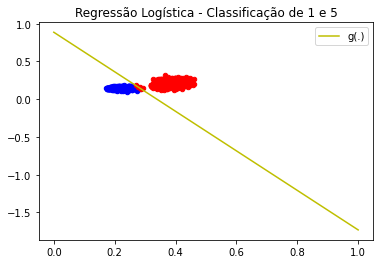

In [514]:
rx = [[1, x[0], x[1]] for x in xtesteut]



cutlog.fit(rx, ytesteut)

# Plota as porcentagens da Regressão Logística
pred = cutlog.predict(rx,cutlog.w)


xRL = [0, +1]


yRL = [cutlog.getRegressionY(x) for x in xRL]
plt.plot(xRL, yRL, 'y-', label='g(.)')
plt.legend(loc='upper right')

# Plota os pontos classificados pela RL com bolinha azul(+) e vermelha(-)
xP = [rx[i][1] for i in range(len(rx)) if pred[i] >= 0.5]
yP = [rx[i][2] for i in range(len(rx)) if pred[i] >= 0.5]
xN = [rx[i][1] for i in range(len(rx)) if pred[i] < 0.5]
yN = [rx[i][2] for i in range(len(rx)) if pred[i] < 0.5]

plt.scatter(xP, yP, color='blue', marker='o', s=20)
plt.scatter(xN, yN, color='red', marker='o', s=20)

plt.title("Regressão Logística - Classificação de 1 e 5")
plt.show()

In [515]:
modelo_metricas(ytesteut, pred)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1      605        0
y +1        6      286

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       0.99      1.00      1.00       605
   dígito +1       1.00      0.98      0.99       292

    accuracy                           0.99       897
   macro avg       1.00      0.99      0.99       897
weighted avg       0.99      0.99      0.99       897

----------------------------------------------------------



In [516]:
best_classifiers_ut.append(getPrecisao(ytesteut, pred))

#### Weight Decay

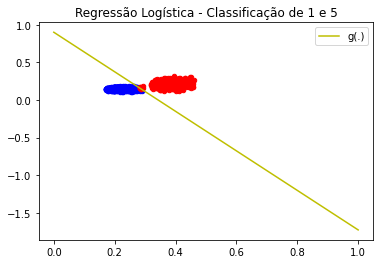

In [517]:
rx = [[1, x[0], x[1]] for x in xtreinut]
cutwd = WeightDecay()

cutwd.fit(rx, ytreinut)

pred = cutwd.predict(rx, cutwd.w)


xRL = [0, +1]
yRL = [cutwd.getRegressionY(x) for x in xRL]

plt.plot(xRL, yRL, 'y-', label='g(.)')
plt.legend(loc='upper right')


xP = [rx[i][1] for i in range(len(rx)) if pred[i] >= 0]
yP = [rx[i][2] for i in range(len(rx)) if pred[i] >= 0]

xN = [rx[i][1] for i in range(len(rx)) if pred[i] < 0]
yN = [rx[i][2] for i in range(len(rx)) if pred[i] < 0]


plt.scatter(xP, yP, color='blue', marker='o', s=20)
plt.scatter(xN, yN, color='red', marker='o', s=20)






plt.title("Regressão Logística - Classificação de 1 e 5")
plt.show()


In [518]:
modelo_metricas(ytreinut, pred)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1     1153        0
y +1       12      596

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       0.99      1.00      0.99      1153
   dígito +1       1.00      0.98      0.99       608

    accuracy                           0.99      1761
   macro avg       0.99      0.99      0.99      1761
weighted avg       0.99      0.99      0.99      1761

----------------------------------------------------------



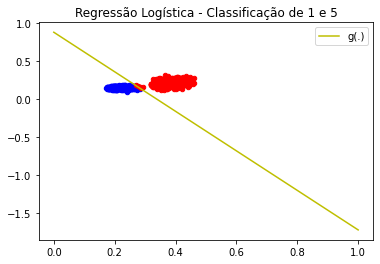

In [519]:
rx = [[1, x[0], x[1]] for x in xtesteut]



cutwd.fit(rx, ytesteut)

pred = cutwd.predict(rx, cutwd.w)


xRL = [0, +1]
yRL = [cutwd.getRegressionY(x) for x in xRL]

plt.plot(xRL, yRL, 'y-', label='g(.)')
plt.legend(loc='upper right')


xP = [rx[i][1] for i in range(len(rx)) if pred[i] >= 0]
yP = [rx[i][2] for i in range(len(rx)) if pred[i] >= 0]

xN = [rx[i][1] for i in range(len(rx)) if pred[i] < 0]
yN = [rx[i][2] for i in range(len(rx)) if pred[i] < 0]


plt.scatter(xP, yP, color='blue', marker='o', s=20)
plt.scatter(xN, yN, color='red', marker='o', s=20)






plt.title("Regressão Logística - Classificação de 1 e 5")
plt.show()


In [520]:
modelo_metricas(ytesteut, pred)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1      605        0
y +1        6      286

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       0.99      1.00      1.00       605
   dígito +1       1.00      0.98      0.99       292

    accuracy                           0.99       897
   macro avg       1.00      0.99      0.99       897
weighted avg       0.99      0.99      0.99       897

----------------------------------------------------------



In [521]:
best_classifiers_ut.append(getPrecisao(ytesteut, pred))

## 4 Vs Resto

In [522]:
treinqt = TreinoRedimensionado.copy()
testeqt = TesteRedimensionado.copy()

# retirar os 0

treinqt = treinqt[treinqt[:,0] != 0] 
testeqt = testeqt[testeqt[:,0] != 0]

# retirar os 1

treinqt = treinqt[treinqt[:,0] != 1]
testeqt = testeqt[testeqt[:,0] != 1]

# Separar em treino e teste, features e labels

xtreinqt = treinqt[:,1:]
xtesteqt = testeqt[:,1:]

ytreinqt = treinqt[:,0]
ytesteqt = testeqt[:,0]


# atribuir 1 para 4 e -1 para o resto

ytreinqt = np.where(ytreinqt == 4, 1, -1)
ytesteqt = np.where(ytesteqt == 4, 1, -1)






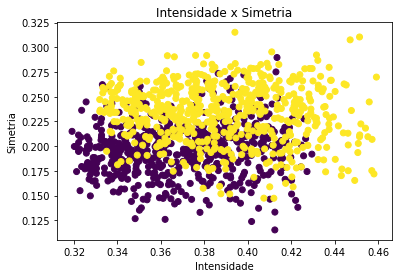

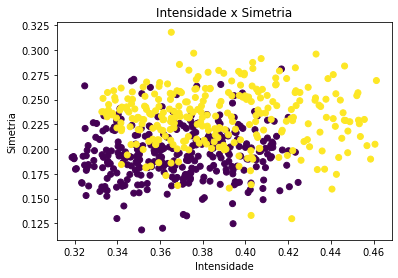

(None, None)

In [523]:
IntensidadeXSimetria(treinqt), IntensidadeXSimetria(testeqt)

#### Linear Regression Classifier

�


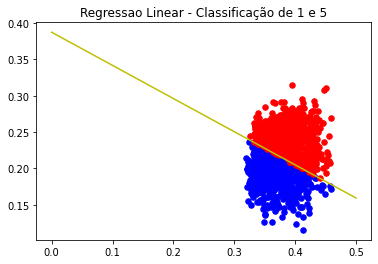

In [524]:
rX = [[1,x[0], x[1]] for x in  xtreinqt]

N = len(rX)

cqtlr = LRClassifier()
cqtlr.execute(rX, ytreinqt)


#desenha a reta inferida pela regressao linear
xOri = [0, +0.5]
yOri = [cqtlr.getRegressionY(xOri[0]), cqtlr.getRegressionY(xOri[1])]
plt.plot(xOri, yOri, '-y', label='RL')
plt.title("Regressao Linear - Classificação de 1 e 5")

#plota os pontos classificados pela RL com bolinha azul(+) e vermelha(-)

pred = [cqtlr.predict(x) for x in rX]

xP = [rX[i][1] for i in range(N) if(pred[i] > 0)] # Vetor de x's dos pontos classificados como +1
yP = [rX[i][2] for i in range(N) if(pred[i] > 0)] # Vetor de y's dos pontos classificados como +1
xN = [rX[i][1] for i in range(N) if(pred[i] < 0)] # Vetor de x's dos pontos classificados como -1
yN = [rX[i][2] for i in range(N) if(pred[i] < 0)] # Vetor de y's dos pontos classificados como -1

plt.scatter(xP, yP, color='blue', marker='o', s=30) 
plt.scatter(xN, yN, color='red', marker='o', s=30)

# plt.scatter([rX[i][1] for i in range(N) if(pred[i] > 0)], [rX[i][2] for i in range(N) if(pred[i] > 0)], color='blue', marker='o', s=30)
# plt.scatter([rX[i][1] for i in range(N) if(pred[i] < 0)], [rX[i][2] for i in range(N) if(pred[i] < 0)], color='red', marker='o', s=30)

# Eixo X = Intensidade Eixo Y = Simetria



plt.show()

In [525]:
modelo_metricas(ytreinqt, pred)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1      435      141
y +1      133      444

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       0.77      0.76      0.76       576
   dígito +1       0.76      0.77      0.76       577

    accuracy                           0.76      1153
   macro avg       0.76      0.76      0.76      1153
weighted avg       0.76      0.76      0.76      1153

----------------------------------------------------------



�


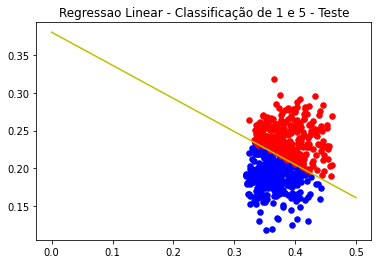

In [526]:

rX = [[1,x[0], x[1]] for x in  xtesteqt]


N = len(rX)


cutlr.execute(rX, ytesteqt)



#desenha a reta inferida pela regressao linear
xOri = [0, +0.5]
yOri = [cutlr.getRegressionY(xOri[0]), cutlr.getRegressionY(xOri[1])]
plt.plot(xOri, yOri, '-y', label='RL')
plt.title("Regressao Linear - Classificação de 1 e 5 - Teste")

#plota os pontos classificados pela RL com bolinha azul(+) e vermelha(-)

pred = [cutlr.predict(x) for x in rX]

xP = [rX[i][1] for i in range(N) if(pred[i] > 0)] # Vetor de x's dos pontos classificados como +1
yP = [rX[i][2] for i in range(N) if(pred[i] > 0)] # Vetor de y's dos pontos classificados como +1
xN = [rX[i][1] for i in range(N) if(pred[i] < 0)] # Vetor de x's dos pontos classificados como -1
yN = [rX[i][2] for i in range(N) if(pred[i] < 0)] # Vetor de y's dos pontos classificados como -1

plt.scatter(xP, yP, color='blue', marker='o', s=30)
plt.scatter(xN, yN, color='red', marker='o', s=30)

# plt.scatter([rX[i][1] for i in range(N) if(pred[i] > 0)], [rX[i][2] for i in range(N) if(pred[i] > 0)], color='blue', marker='o', s=30)
# plt.scatter([rX[i][1] for i in range(N) if(pred[i] < 0)], [rX[i][2] for i in range(N) if(pred[i] < 0)], color='red', marker='o', s=30)

plt.show()



In [527]:
modelo_metricas(ytesteqt, pred)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1      217       74
y +1       66      248

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       0.77      0.75      0.76       291
   dígito +1       0.77      0.79      0.78       314

    accuracy                           0.77       605
   macro avg       0.77      0.77      0.77       605
weighted avg       0.77      0.77      0.77       605

----------------------------------------------------------



In [528]:
len(ytesteqt), len(pred)

(605, 605)

In [529]:
best_classifiers_qt.append(getPrecisao(ytesteqt, pred))

#### Pocket PLA

Número de iterações:  99


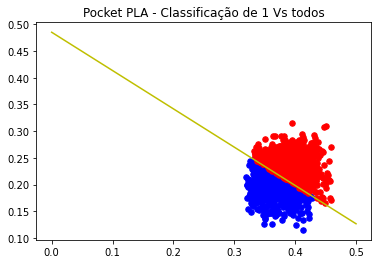

In [530]:
# executa o PLA sobre os dados de entrada X e y
rX = [[1, x[0], x[1]] for x in xtreinqt]


cqtpp = PocketPLA()
cqtpp.execute(rX, ytreinqt)

# desenha a reta inferida pelo PLA
xOri = [0, +0.5]
yOri = [cqtpp.getOriginalY(x) for x in xOri]

plt.plot(xOri, yOri, '-y', label='g(.)')  # reta inferida pelo PLA


predict = [cqtpp.predict(x) for x in rX]

xP = [rX[i][1] for i in range(len(rX)) if predict[i] > 0]
yP = [rX[i][2] for i in range(len(rX)) if predict[i] > 0]

xN = [rX[i][1] for i in range(len(rX)) if predict[i] < 0]
yN = [rX[i][2] for i in range(len(rX)) if predict[i] < 0]

plt.scatter(xP, yP, color='blue', marker='o', s=30)
plt.scatter(xN, yN, color='red', marker='o', s=30)
plt.title("Pocket PLA - Classificação de 1 Vs todos")
plt.show()

In [531]:
modelo_metricas(ytreinqt, predict)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1      438      138
y +1      143      434

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       0.75      0.76      0.76       576
   dígito +1       0.76      0.75      0.76       577

    accuracy                           0.76      1153
   macro avg       0.76      0.76      0.76      1153
weighted avg       0.76      0.76      0.76      1153

----------------------------------------------------------



Número de iterações:  99


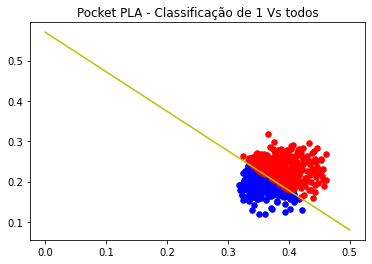

In [532]:
# executa o PLA sobre os dados de entrada X e y
rX = [[1, x[0], x[1]] for x in xtesteqt]



cqtpp.execute(rX, ytesteqt)

# desenha a reta inferida pelo PLA
xOri = [0, +0.5]
yOri = [cqtpp.getOriginalY(x) for x in xOri]

plt.plot(xOri, yOri, '-y', label='g(.)')  # reta inferida pelo PLA


predict = [cqtpp.predict(x) for x in rX]

xP = [rX[i][1] for i in range(len(rX)) if predict[i] > 0]
yP = [rX[i][2] for i in range(len(rX)) if predict[i] > 0]

xN = [rX[i][1] for i in range(len(rX)) if predict[i] < 0]
yN = [rX[i][2] for i in range(len(rX)) if predict[i] < 0]

plt.scatter(xP, yP, color='blue', marker='o', s=30)
plt.scatter(xN, yN, color='red', marker='o', s=30)
plt.title("Pocket PLA - Classificação de 1 Vs todos")
plt.show()

In [533]:
modelo_metricas(ytesteqt, predict)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1      247       44
y +1      110      204

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       0.69      0.85      0.76       291
   dígito +1       0.82      0.65      0.73       314

    accuracy                           0.75       605
   macro avg       0.76      0.75      0.74       605
weighted avg       0.76      0.75      0.74       605

----------------------------------------------------------



In [534]:
best_classifiers_qt.append(getPrecisao(ytesteqt, predict))

#### Logistic Regression Classifier

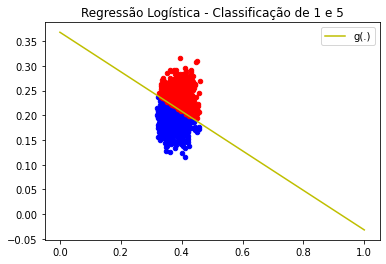

In [535]:
rx = [[1, x[0], x[1]] for x in xtreinqt]

# Executar o ajuste dos dados com Regressão Logística
cqtlog = LogisticRegression_1()

cqtlog.fit(rx, ytreinqt)

# Plota as porcentagens da Regressão Logística
pred = cqtlog.predict(rx,cqtlog.w)


xRL = [0, +1]


yRL = [cqtlog.getRegressionY(x) for x in xRL]
plt.plot(xRL, yRL, 'y-', label='g(.)')
plt.legend(loc='upper right')

# Plota os pontos classificados pela RL com bolinha azul(+) e vermelha(-)
xP = [rx[i][1] for i in range(len(rx)) if pred[i] >= 0.5]
yP = [rx[i][2] for i in range(len(rx)) if pred[i] >= 0.5]
xN = [rx[i][1] for i in range(len(rx)) if pred[i] < 0.5]
yN = [rx[i][2] for i in range(len(rx)) if pred[i] < 0.5]

plt.scatter(xP, yP, color='blue', marker='o', s=20)
plt.scatter(xN, yN, color='red', marker='o', s=20)

plt.title("Regressão Logística - Classificação de 1 e 5")
plt.show()

In [536]:
modelo_metricas(ytreinqt, pred)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1      428      148
y +1      119      458

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       0.78      0.74      0.76       576
   dígito +1       0.76      0.79      0.77       577

    accuracy                           0.77      1153
   macro avg       0.77      0.77      0.77      1153
weighted avg       0.77      0.77      0.77      1153

----------------------------------------------------------



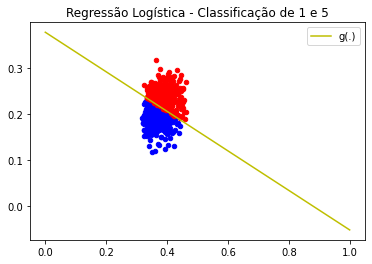

In [537]:
rx = [[1, x[0], x[1]] for x in xtesteqt]



cqtlog.fit(rx, ytesteqt)

# Plota as porcentagens da Regressão Logística
pred = cqtlog.predict(rx,cqtlog.w)


xRL = [0, +1]


yRL = [cqtlog.getRegressionY(x) for x in xRL]
plt.plot(xRL, yRL, 'y-', label='g(.)')
plt.legend(loc='upper right')

# Plota os pontos classificados pela RL com bolinha azul(+) e vermelha(-)
xP = [rx[i][1] for i in range(len(rx)) if pred[i] >= 0.5]
yP = [rx[i][2] for i in range(len(rx)) if pred[i] >= 0.5]
xN = [rx[i][1] for i in range(len(rx)) if pred[i] < 0.5]
yN = [rx[i][2] for i in range(len(rx)) if pred[i] < 0.5]

plt.scatter(xP, yP, color='blue', marker='o', s=20)
plt.scatter(xN, yN, color='red', marker='o', s=20)

plt.title("Regressão Logística - Classificação de 1 e 5")
plt.show()

In [538]:
modelo_metricas(ytesteqt, pred)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1      216       75
y +1       63      251

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       0.77      0.74      0.76       291
   dígito +1       0.77      0.80      0.78       314

    accuracy                           0.77       605
   macro avg       0.77      0.77      0.77       605
weighted avg       0.77      0.77      0.77       605

----------------------------------------------------------



In [539]:
best_classifiers_qt.append(getPrecisao(ytesteqt, pred))

#### Weight Decay

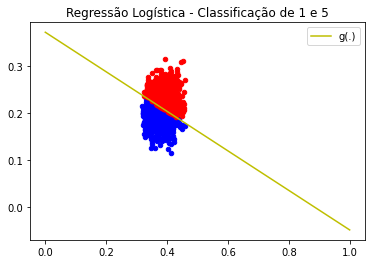

In [540]:
rx = [[1, x[0], x[1]] for x in xtreinqt]

cqtwd = WeightDecay()

cqtwd.fit(rx, ytreinqt)

pred = cqtwd.predict(rx, cqtwd.w)


xRL = [0, +1]
yRL = [cqtwd.getRegressionY(x) for x in xRL]

plt.plot(xRL, yRL, 'y-', label='g(.)')
plt.legend(loc='upper right')


xP = [rx[i][1] for i in range(len(rx)) if pred[i] >= 0]
yP = [rx[i][2] for i in range(len(rx)) if pred[i] >= 0]

xN = [rx[i][1] for i in range(len(rx)) if pred[i] < 0]
yN = [rx[i][2] for i in range(len(rx)) if pred[i] < 0]


plt.scatter(xP, yP, color='blue', marker='o', s=20)
plt.scatter(xN, yN, color='red', marker='o', s=20)






plt.title("Regressão Logística - Classificação de 1 e 5")
plt.show()


In [541]:
modelo_metricas(ytreinqt, pred)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1      448      128
y +1      149      428

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       0.75      0.78      0.76       576
   dígito +1       0.77      0.74      0.76       577

    accuracy                           0.76      1153
   macro avg       0.76      0.76      0.76      1153
weighted avg       0.76      0.76      0.76      1153

----------------------------------------------------------



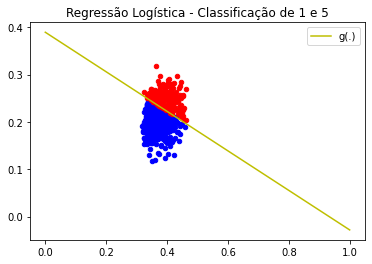

In [542]:
rx = [[1, x[0], x[1]] for x in xtesteqt]



cqtwd.fit(rx, ytesteqt)

pred = cqtwd.predict(rx, cqtwd.w)


xRL = [0, +1]
yRL = [cqtwd.getRegressionY(x) for x in xRL]

plt.plot(xRL, yRL, 'y-', label='g(.)')
plt.legend(loc='upper right')


xP = [rx[i][1] for i in range(len(rx)) if pred[i] >= 0]
yP = [rx[i][2] for i in range(len(rx)) if pred[i] >= 0]

xN = [rx[i][1] for i in range(len(rx)) if pred[i] < 0]
yN = [rx[i][2] for i in range(len(rx)) if pred[i] < 0]


plt.scatter(xP, yP, color='blue', marker='o', s=20)
plt.scatter(xN, yN, color='red', marker='o', s=20)






plt.title("Regressão Logística - Classificação de 1 e 5")
plt.show()


In [543]:
modelo_metricas(ytesteqt, pred)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1      148      143
y +1       25      289

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       0.86      0.51      0.64       291
   dígito +1       0.67      0.92      0.77       314

    accuracy                           0.72       605
   macro avg       0.76      0.71      0.71       605
weighted avg       0.76      0.72      0.71       605

----------------------------------------------------------



In [544]:
best_classifiers_qt.append(getPrecisao(ytesteqt, pred))

## 5 Vs Resto

In [545]:
# teste15 = TesteRedimensionado[np.where((TesteRedimensionado[:,0] == 1) | (TesteRedimensionado[:,0] == 5))]
treinoct = TreinoRedimensionado.copy()
testect = TesteRedimensionado.copy()

xtreinoct = treinoct[:,1:]
xtestect = testect[:,1:]

ytreinoct = treinoct[:,0]
ytestect = testect[:,0]


# Atriuir 1 para 0 e -1 para o resto

ytreinoct = np.where(ytreinoct == 5, 1, -1)
ytestect = np.where(ytestect == 5, 1, -1)





##### Linear regression

�


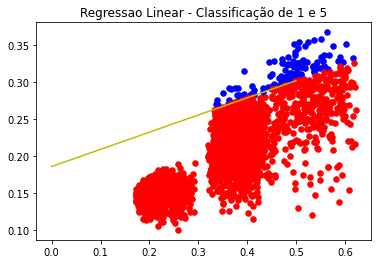

In [546]:
rX = [[1,x[0], x[1]] for x in  xtreinoct]

N = len(rX)

cctlr = LRClassifier()
cctlr.execute(rX, ytreinoct)


#desenha a reta inferida pela regressao linear
xOri = [0, +0.5]
yOri = [cctlr.getRegressionY(xOri[0]), cctlr.getRegressionY(xOri[1])]
plt.plot(xOri, yOri, '-y', label='RL')
plt.title("Regressao Linear - Classificação de 1 e 5")

#plota os pontos classificados pela RL com bolinha azul(+) e vermelha(-)

pred = [cctlr.predict(x) for x in rX]

xP = [rX[i][1] for i in range(N) if(pred[i] > 0)] # Vetor de x's dos pontos classificados como +1
yP = [rX[i][2] for i in range(N) if(pred[i] > 0)] # Vetor de y's dos pontos classificados como +1
xN = [rX[i][1] for i in range(N) if(pred[i] < 0)] # Vetor de x's dos pontos classificados como -1
yN = [rX[i][2] for i in range(N) if(pred[i] < 0)] # Vetor de y's dos pontos classificados como -1

plt.scatter(xP, yP, color='blue', marker='o', s=30) 
plt.scatter(xN, yN, color='red', marker='o', s=30)

# plt.scatter([rX[i][1] for i in range(N) if(pred[i] > 0)], [rX[i][2] for i in range(N) if(pred[i] > 0)], color='blue', marker='o', s=30)
# plt.scatter([rX[i][1] for i in range(N) if(pred[i] < 0)], [rX[i][2] for i in range(N) if(pred[i] < 0)], color='red', marker='o', s=30)

# Eixo X = Intensidade Eixo Y = Simetria



plt.show()

�


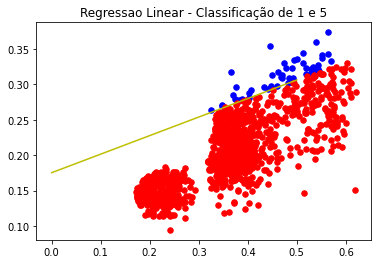

In [547]:
rX = [[1,x[0], x[1]] for x in  xtestect]

N = len(rX)

cctlr.execute(rX, ytestect)


#desenha a reta inferida pela regressao linear
xOri = [0, +0.5]
yOri = [cctlr.getRegressionY(xOri[0]), cctlr.getRegressionY(xOri[1])]
plt.plot(xOri, yOri, '-y', label='RL')
plt.title("Regressao Linear - Classificação de 1 e 5")

#plota os pontos classificados pela RL com bolinha azul(+) e vermelha(-)

pred = [cctlr.predict(x) for x in rX]

xP = [rX[i][1] for i in range(N) if(pred[i] > 0)] # Vetor de x's dos pontos classificados como +1
yP = [rX[i][2] for i in range(N) if(pred[i] > 0)] # Vetor de y's dos pontos classificados como +1
xN = [rX[i][1] for i in range(N) if(pred[i] < 0)] # Vetor de x's dos pontos classificados como -1
yN = [rX[i][2] for i in range(N) if(pred[i] < 0)] # Vetor de y's dos pontos classificados como -1

plt.scatter(xP, yP, color='blue', marker='o', s=30) 
plt.scatter(xN, yN, color='red', marker='o', s=30)

# plt.scatter([rX[i][1] for i in range(N) if(pred[i] > 0)], [rX[i][2] for i in range(N) if(pred[i] > 0)], color='blue', marker='o', s=30)
# plt.scatter([rX[i][1] for i in range(N) if(pred[i] < 0)], [rX[i][2] for i in range(N) if(pred[i] < 0)], color='red', marker='o', s=30)

# Eixo X = Intensidade Eixo Y = Simetria



plt.show()

In [548]:
modelo_metricas(ytestect, pred)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1      785       39
y +1      281       10

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       0.74      0.95      0.83       824
   dígito +1       0.20      0.03      0.06       291

    accuracy                           0.71      1115
   macro avg       0.47      0.49      0.44      1115
weighted avg       0.60      0.71      0.63      1115

----------------------------------------------------------



In [549]:
best_classifiers_ct.append(getPrecisao(ytestect, pred))

#### Pocket Pla

Número de iterações:  99


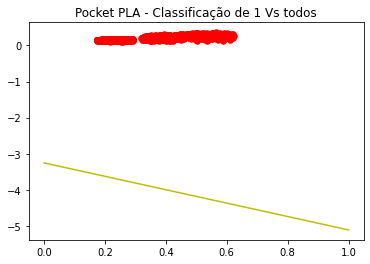

In [550]:
# executa o PLA sobre os dados de entrada X e y
rX = [[1, x[0], x[1]] for x in xtreinoct]


cctpp = PocketPLA()
cctpp.execute(rX, ytreinoct)

# desenha a reta inferida pelo PLA
xOri = [0, +1]
yOri = [cctpp.getOriginalY(x) for x in xOri]

plt.plot(xOri, yOri, '-y', label='g(.)')  # reta inferida pelo PLA


predict = [cctpp.predict(x) for x in rX]

xP = [rX[i][1] for i in range(len(rX)) if predict[i] > 0]
yP = [rX[i][2] for i in range(len(rX)) if predict[i] > 0]

xN = [rX[i][1] for i in range(len(rX)) if predict[i] < 0]
yN = [rX[i][2] for i in range(len(rX)) if predict[i] < 0]

plt.scatter(xP, yP, color='blue', marker='o', s=30)
plt.scatter(xN, yN, color='red', marker='o', s=30)
plt.title("Pocket PLA - Classificação de 1 Vs todos")
plt.show()

Número de iterações:  99


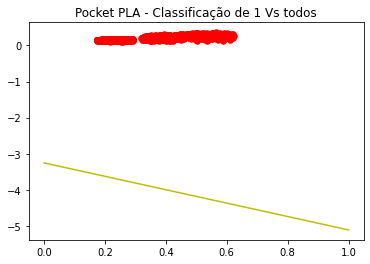

In [551]:
# executa o PLA sobre os dados de entrada X e y
rX = [[1, x[0], x[1]] for x in xtreinoct]



cctpp.execute(rX, ytreinoct)

# desenha a reta inferida pelo PLA
xOri = [0, +1]
yOri = [cctpp.getOriginalY(x) for x in xOri]

plt.plot(xOri, yOri, '-y', label='g(.)')  # reta inferida pelo PLA


predict = [cctpp.predict(x) for x in rX]

xP = [rX[i][1] for i in range(len(rX)) if predict[i] > 0]
yP = [rX[i][2] for i in range(len(rX)) if predict[i] > 0]

xN = [rX[i][1] for i in range(len(rX)) if predict[i] < 0]
yN = [rX[i][2] for i in range(len(rX)) if predict[i] < 0]

plt.scatter(xP, yP, color='blue', marker='o', s=30)
plt.scatter(xN, yN, color='red', marker='o', s=30)
plt.title("Pocket PLA - Classificação de 1 Vs todos")
plt.show()

In [552]:
modelo_metricas(ytreinoct, predict)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1     1610        0
y +1      576        0

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       0.74      1.00      0.85      1610
   dígito +1       0.00      0.00      0.00       576

    accuracy                           0.74      2186
   macro avg       0.37      0.50      0.42      2186
weighted avg       0.54      0.74      0.62      2186

----------------------------------------------------------



In [553]:
best_classifiers_ct.append(getPrecisao(ytreinoct, predict))

#### Logistic Regression

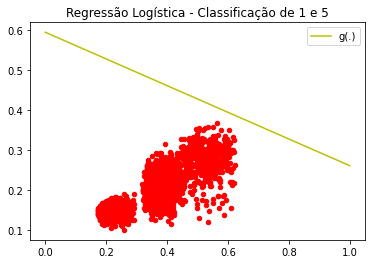

In [554]:
rx = [[1, x[0], x[1]] for x in xtreinoct]

# Executar o ajuste dos dados com Regressão Logística
#classifier = LogisticRegression_1()
cctlog = LogisticRegression_1(0.1, 10000, 64)
#classifier = LogisticRegressionGradientDescendent()


cctlog.fit(rx, ytreinoct)

# Plota as porcentagens da Regressão Logística
pred = clog15.predict(rx,cctlog.w)



# Desenha a reta inferida pela regressão logística
xRL = [0, +1]


yRL = [cctlog.getRegressionY(x) for x in xRL]
plt.plot(xRL, yRL, 'y-', label='g(.)')
plt.legend(loc='upper right')

# Plota os pontos classificados pela RL com bolinha azul(+) e vermelha(-)
xP = [rx[i][1] for i in range(len(rx)) if pred[i] >= 0.5]
yP = [rx[i][2] for i in range(len(rx)) if pred[i] >= 0.5]
xN = [rx[i][1] for i in range(len(rx)) if pred[i] < 0.5]
yN = [rx[i][2] for i in range(len(rx)) if pred[i] < 0.5]

plt.scatter(xP, yP, color='blue', marker='o', s=20)
plt.scatter(xN, yN, color='red', marker='o', s=20)

plt.title("Regressão Logística - Classificação de 1 e 5")
plt.show()

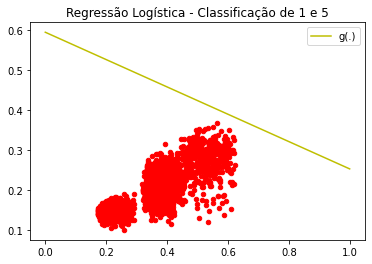

In [555]:
rx = [[1, x[0], x[1]] for x in xtreinoct]

# Executar o ajuste dos dados com Regressão Logística



cctlog.fit(rx, ytreinoct)

# Plota as porcentagens da Regressão Logística
pred = clog15.predict(rx,cctlog.w)



# Desenha a reta inferida pela regressão logística
xRL = [0, +1]


yRL = [cctlog.getRegressionY(x) for x in xRL]
plt.plot(xRL, yRL, 'y-', label='g(.)')
plt.legend(loc='upper right')

# Plota os pontos classificados pela RL com bolinha azul(+) e vermelha(-)
xP = [rx[i][1] for i in range(len(rx)) if pred[i] >= 0.5]
yP = [rx[i][2] for i in range(len(rx)) if pred[i] >= 0.5]
xN = [rx[i][1] for i in range(len(rx)) if pred[i] < 0.5]
yN = [rx[i][2] for i in range(len(rx)) if pred[i] < 0.5]

plt.scatter(xP, yP, color='blue', marker='o', s=20)
plt.scatter(xN, yN, color='red', marker='o', s=20)

plt.title("Regressão Logística - Classificação de 1 e 5")
plt.show()

In [556]:
modelo_metricas(ytreinoct, pred)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1     1610        0
y +1      576        0

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       0.74      1.00      0.85      1610
   dígito +1       0.00      0.00      0.00       576

    accuracy                           0.74      2186
   macro avg       0.37      0.50      0.42      2186
weighted avg       0.54      0.74      0.62      2186

----------------------------------------------------------



In [557]:
best_classifiers_ct.append(getPrecisao(ytreinoct, pred))

#### Weight Decay

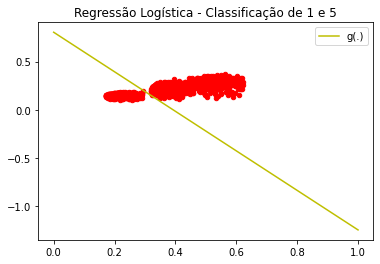

In [558]:
rx = [[1, x[0], x[1]] for x in xtreinoct]

cctwd = WeightDecay()

cctwd.fit(rx, ytreinoct)

pred = cctwd.predict(rx, cctwd.w)


xRL = [0, +1]
yRL = [wd15.getRegressionY(x) for x in xRL]

plt.plot(xRL, yRL, 'y-', label='g(.)')
plt.legend(loc='upper right')


xP = [rx[i][1] for i in range(len(rx)) if pred[i] >= 0]
yP = [rx[i][2] for i in range(len(rx)) if pred[i] >= 0]

xN = [rx[i][1] for i in range(len(rx)) if pred[i] < 0]
yN = [rx[i][2] for i in range(len(rx)) if pred[i] < 0]


plt.scatter(xP, yP, color='blue', marker='o', s=20)
plt.scatter(xN, yN, color='red', marker='o', s=20)






plt.title("Regressão Logística - Classificação de 1 e 5")
plt.show()


In [559]:
modelo_metricas(ytreinoct, pred)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1     1610        0
y +1      576        0

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       0.74      1.00      0.85      1610
   dígito +1       0.00      0.00      0.00       576

    accuracy                           0.74      2186
   macro avg       0.37      0.50      0.42      2186
weighted avg       0.54      0.74      0.62      2186

----------------------------------------------------------



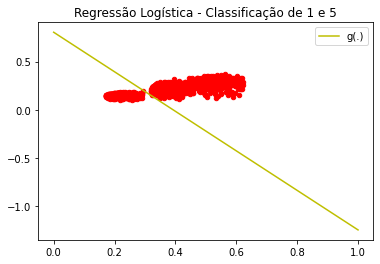

In [560]:
rx = [[1, x[0], x[1]] for x in xtreinoct]



cctwd.fit(rx, ytreinoct)

pred = cctwd.predict(rx, cctwd.w)


xRL = [0, +1]
yRL = [wd15.getRegressionY(x) for x in xRL]

plt.plot(xRL, yRL, 'y-', label='g(.)')
plt.legend(loc='upper right')


xP = [rx[i][1] for i in range(len(rx)) if pred[i] >= 0]
yP = [rx[i][2] for i in range(len(rx)) if pred[i] >= 0]

xN = [rx[i][1] for i in range(len(rx)) if pred[i] < 0]
yN = [rx[i][2] for i in range(len(rx)) if pred[i] < 0]


plt.scatter(xP, yP, color='blue', marker='o', s=20)
plt.scatter(xN, yN, color='red', marker='o', s=20)






plt.title("Regressão Logística - Classificação de 1 e 5")
plt.show()


In [561]:
modelo_metricas(ytreinoct, pred)

------------------ Matriz de confusão ------------------

      pred -1  pred +1
y -1     1610        0
y +1      576        0

-------- Relatório de eficácia de classificação --------

              precision    recall  f1-score   support

   dígito -1       0.74      1.00      0.85      1610
   dígito +1       0.00      0.00      0.00       576

    accuracy                           0.74      2186
   macro avg       0.37      0.50      0.42      2186
weighted avg       0.54      0.74      0.62      2186

----------------------------------------------------------



In [562]:
best_classifiers_ct.append(getPrecisao(ytreinoct, pred))

## Função Para classificação Multiclasse


Ao final serão construídas três funções hipótese que juntas irão realizar a classificação
multiclasse dos quatro dígitos. Seja 𝑥 a imagem teste a ser classificada, classifique 𝑥 com o
seguinte algoritmo: 
para os dígitos 𝑖 ∈ [0,1,4] 
se 𝑓𝑖
(𝑥) = +1
classifique como dígito i
senão
se i == 4
classifique como dígito 5
3.4. Comparação entre os classificadore

In [563]:
len(best_classifiers_zt), len(best_classifiers_ut), len(best_classifiers_qt), len(best_classifiers_ct)

(4, 4, 4, 4)

In [564]:
classifiers_ = ["LinearRegression","Pocket_PLA","LogisticRegression_1", "WeightDecay"]

# Melhores classificadores para cada classe

classifiers_zt = [cztlr,cztpp,cztlog,cztwd]
classifiers_ut = [cutlr,cutpp,cutlog,cutwd]
classifiers_qt = [cqtlr,cqtpp,cqtlog,cqtwd]
classifiers_ct = [cctlr,cctpp,cctlog,cctwd]

In [565]:
# Retorne o index do melhor classificador de cada tipo

print("Melhor classificador de Z: ", classifiers_[best_classifiers_zt.index(max(best_classifiers_zt))])
print("Melhor classificador de U: ", classifiers_[best_classifiers_ut.index(max(best_classifiers_ut))])
print("Melhor classificador de Q: ", classifiers_[best_classifiers_qt.index(max(best_classifiers_qt))])
print("Melhor classificador de C: ", classifiers_[best_classifiers_ct.index(max(best_classifiers_ct))])

Melhor classificador de Z:  Pocket_PLA
Melhor classificador de U:  LinearRegression
Melhor classificador de Q:  LogisticRegression_1
Melhor classificador de C:  Pocket_PLA


In [566]:
# Retorne o melhor classificador de cada tipo

BestClassifiers = [classifiers_zt[best_classifiers_zt.index(max(best_classifiers_zt))], classifiers_ut[best_classifiers_ut.index(max(best_classifiers_ut))], classifiers_qt[best_classifiers_qt.index(max(best_classifiers_qt))], classifiers_ct[best_classifiers_ct.index(max(best_classifiers_ct))]]

In [587]:
# Classificação Multiclasse

def Classify(x, BestClassifiers):
   
    # para os dígitos 𝑖 ∈ [0,1,4] 
    # se 𝑓𝑖(𝑥) = +1
    # classifique como dígito i
    # senão
    # se i == 4
    # classifique como dígito 5
    
    # x é um vetor de duas dimensões, que representa os atributos intensidade e simetria
    
    for i in range(len(BestClassifiers)):
        print("Classificando com ", i)
        if BestClassifiers[i].predict(x, BestClassifiers[i].w) == 1:
            #print("Classificado como ", i)
            return i
            
        elif i == 2:
           # print("Classificado como 5")
            return 5
        
    
        
    

In [568]:
def ClassifyAll(X, BestClassifiers):
    # Classifica todos os elementos de X e retorna a acurácia
    
    acertos = 0
    
    for x in range(len(X)):
        
        if Classify(X[x], BestClassifiers) == X[x][0]: #  Se a classificação for correta usaando os classificadores 
            acertos += 1
        else:
            
            print("Classificado como ", Classify(X[x], BestClassifiers), " - Real: ", X[x][0])
    
    print("Acurácia: ", acertos/len(X))
    return acertos/len(X)
    

In [584]:
# Criar todas as combinações possíveis de ordem de classificação para 0,1,4,5

# 0,1,4,5 / 0, 1, 5, 4 / 0, 4, 1, 5 / 0, 4, 5, 1 / 0, 5, 1, 4 / 0, 5, 4, 1 --> exemplo

from itertools import permutations

ordem = [0, 1, 2, 3]

# Gerar todas as permutações possíveis
permutacoes = list(permutations(ordem))

ordens = []

# Imprimir as permutações
for perm in permutacoes:
    print(perm)
    ordens.append(perm)




(0, 1, 2, 3)
(0, 1, 3, 2)
(0, 2, 1, 3)
(0, 2, 3, 1)
(0, 3, 1, 2)
(0, 3, 2, 1)
(1, 0, 2, 3)
(1, 0, 3, 2)
(1, 2, 0, 3)
(1, 2, 3, 0)
(1, 3, 0, 2)
(1, 3, 2, 0)
(2, 0, 1, 3)
(2, 0, 3, 1)
(2, 1, 0, 3)
(2, 1, 3, 0)
(2, 3, 0, 1)
(2, 3, 1, 0)
(3, 0, 1, 2)
(3, 0, 2, 1)
(3, 1, 0, 2)
(3, 1, 2, 0)
(3, 2, 0, 1)
(3, 2, 1, 0)


In [593]:

Acertos = [] #  Lista de acertos para cada ordem
 
for i in range(len(ordens)):
    
  
    
    ordenClassif = [BestClassifiers[ordens[i][0]], BestClassifiers[ordens[i][1]], BestClassifiers[ordens[i][2]], BestClassifiers[ordens[i][3]]] # Melhores classificadores para a ordem i
    
    Acertos.append(ClassifyAll(rx,ordenClassif)) # Classificar todos os elementos de rx com a ordem i
    print("Acurácia: ", Acertos[i])
    print("\n\n")

Classificando com  0
Classificando com  0
Classificado como  0  - Real:  1
Classificando com  0
Classificando com  0
Classificado como  0  - Real:  1
Classificando com  0
Classificando com  0
Classificado como  0  - Real:  1
Classificando com  0
Classificando com  0
Classificado como  0  - Real:  1
Classificando com  0
Classificando com  0
Classificado como  0  - Real:  1
Classificando com  0
Classificando com  0
Classificado como  0  - Real:  1
Classificando com  0
Classificando com  0
Classificado como  0  - Real:  1
Classificando com  0
Classificando com  0
Classificado como  0  - Real:  1
Classificando com  0
Classificando com  0
Classificado como  0  - Real:  1
Classificando com  0
Classificando com  0
Classificado como  0  - Real:  1
Classificando com  0
Classificando com  0
Classificado como  0  - Real:  1
Classificando com  0
Classificando com  0
Classificado como  0  - Real:  1
Classificando com  0
Classificando com  0
Classificado como  0  - Real:  1
Classificando com  0
Clas

In [592]:
# Retornar a ordem com a maior acurácia --> 0, 1, 4, 5 (substuir 2 por 4 e 3 por 5)

mOrdem = ordens[Acertos.index(max(Acertos))]

# replace 2 by 4 and 3 by 5

mOrdem = np.array(mOrdem)

mOrdem[mOrdem == 2] = 4
mOrdem[mOrdem == 3] = 5

print("Melhor ordem: ", mOrdem)

Melhor ordem:  [5 4 0 1]
